In [1]:
import cupy as cp
import numpy as np
import pandas as pd
from types import SimpleNamespace

from utils import *
from rec import Rec

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 128  # object size in each dimension
ntheta = 128  # number of angles (rotations)
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

ndist = 4 # number of distances from the focal spot in holotomography
detector_pixelsize = 3e-6 # detector pixel size
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # focus to detector distance [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0 # distances
# z1+=0.3e-3
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance # adjusted distances
magnifications = focusToDetectorDistance/z1 # magnifications
voxelsize = detector_pixelsize/magnifications[0]*2048/n/2  # object voxel size

norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = distances*norm_magnifications**2 # readjusted distances
npsi = int(np.ceil(n/norm_magnifications[-1]/8))*8  # reconstructed object size based on magnification and detector size


In [3]:
args = SimpleNamespace()
args.n = n
args.nq = n
args.ndist = ndist
args.ntheta = ntheta
args.npsi = npsi

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distances
# args.distancep = distancesp
args.rotation_axis = args.npsi/2

args.theta = theta
args.norm_magnifications = norm_magnifications
args.nchunk=8
args.ngpus=4
args.pad = 0

# create class
cl_rec = Rec(args)

## Read data

In [4]:
u=cp.load('u.npy')
nn = u.shape[-1]
u = u[nn//2-npsi//2:nn//2+npsi//2,nn//2-npsi//2:nn//2+npsi//2,nn//2-npsi//2:nn//2+npsi//2]

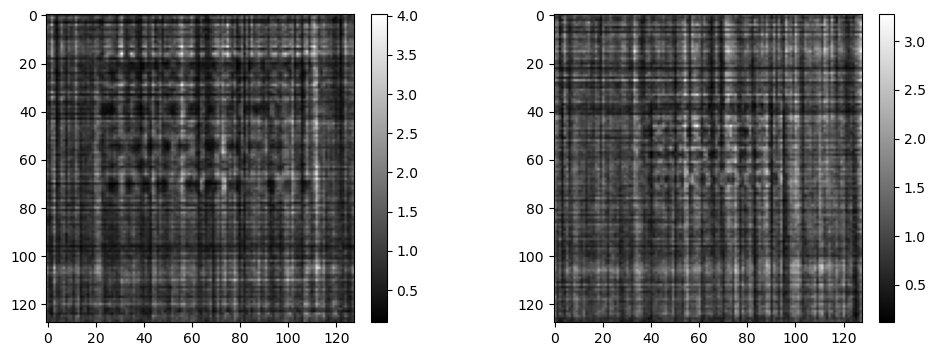

In [5]:
data = cp.load('data.npy')
ref = cp.load('ref.npy')
r = cp.load('shifts.npy')[:ntheta]
mshow_complex(data[0,0]+1j*data[0,-1],True)

# Back propagate probe for the intial guess

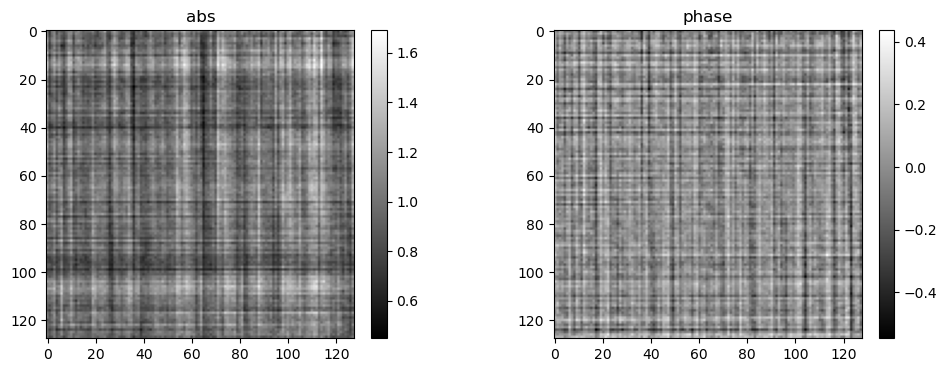

In [6]:
q_init = cp.ones([args.ndist,args.n,args.n],dtype='complex64')
for k in range(args.ndist):
    q_init[k] = cl_rec.DT(cp.sqrt(ref[k:k+1]).astype('complex64'),k)
mshow_polar(q_init[0],True)


# Reconstruct

In [7]:
args.niter=0 # number of iters
args.vis_step=32 # show visualization step
args.err_step=4# show error step
args.path_out='/local/data/out00' # output forlder for dumped results for each vis step
args.show=True # show visualization or not
args.rho=[1,25,15] # scaling of variables to control the convergence
args.lam=0
args.eps=0

cl_rec = Rec(args)

vars={}
vars["u"] = cp.zeros([npsi,npsi,npsi],dtype='complex64')

# q_init = cp.zeros([ndist,n,n],dtype='float32')
# for k in range(ndist):
#     q_init[k] = cp.angle(cl_rec.D(cp.load('q.npy')[k],k))

vars["q"] = q_init.copy()


vars["r"] = cp.load('shifts.npy')[:ntheta]
vars["r_init"] = cp.load('shifts.npy')[:ntheta]+cp.load('shifts_err.npy')[:ntheta]
vars["psi"] = cl_rec.R(vars['u'])        

vars["psi"][:] = cl_rec.expR(vars["psi"])        
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])  #monitor convregence

vars = cl_rec.BH(cp.sqrt(data),cp.sqrt(ref), vars)  

psi = vars['psi']
u = vars['u']
r = vars['r']
q = vars['q']


# x = cp.random.random(data.shape).astype('float32')
# b = cl_rec.F0(x)
# c = cl_rec.F0_new(x.get())
# print(np.linalg.norm(b))
# print(np.linalg.norm(c))


# x = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# y = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# b = cl_rec.dF0(x,y)
# c = cl_rec.dF0_new(x.get(),y.get())
# print(np.linalg.norm(b))
# print(np.linalg.norm(c))


# x = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# y = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# b = cl_rec.gF0(x,y)
# c = cl_rec.gF0_new(x.get(),y.get())
# print(np.linalg.norm(b))
# print(np.linalg.norm(c))

# x = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# y = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# z = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# b = cl_rec.d2F0(x,y,z)
# c = cl_rec.d2F0_new(x.get(),y.get(),z.get())
# print(np.linalg.norm(b))
# print(np.linalg.norm(c))

# x21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x22 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# b = cl_rec.F1([x21,x22])
# c = cl_rec.F1_new([x21,x22.get()])
# print(np.linalg.norm(b))
# print(np.linalg.norm(c))

# x21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x22 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# y21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# y22 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# b0,b1 = cl_rec.dF1([x21,x22],[y21,y22])
# c0,c1 = cl_rec.dF1_new([x21,x22.get()],[y21,y22.get()])
# print(np.linalg.norm(b0))
# print(np.linalg.norm(c0))
# print(np.linalg.norm(b1))
# print(np.linalg.norm(c1))

# x11 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x12 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# x13 = (cp.random.random(r.shape)).astype('float32')
# x14 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')
# y11 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')

# [b0,b1] = cl_rec.gF1([x11,x12,x13,x14],y11)
# [c0,c1] = cl_rec.gF1_new([x11,x12.get(),x13.get(),x14.get()],y11.get())
# print(np.linalg.norm(b0))
# print(np.linalg.norm(c0))
# print(np.linalg.norm(b1))
# print(np.linalg.norm(c1))

# x21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x22 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# y21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# y22 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')
# z21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# z22 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')

# b = cl_rec.d2F1([x21,x22],[y21,y22],[z21,z22])
# c = cl_rec.d2F1_new([x21,x22],[y21,y22],[z21,z22])
# d = cl_rec.d2F1_new([x21,x22.get()],[y21,y22.get()],[z21,z22.get()])
# print(np.linalg.norm(b))
# print(np.linalg.norm(c))
# print(np.linalg.norm(d))

# b = cl_rec.d2F1([x21,x22],[y21,y22],[y21,y22])
# c = cl_rec.d2F1_new([x21,x22],[y21,y22],[y21,y22])
# d = cl_rec.d2F1_new([x21,x22.get()],[y21,y22.get()],[y21,y22.get()])
# print(np.linalg.norm(b))
# print(np.linalg.norm(c))
# print(np.linalg.norm(d))


# x31 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x32 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')
# x33 = (cp.random.random(r.shape)).astype('float32')

# [b0,b1] = cl_rec.F2([x31,x32,x33])
# [c0,c1] = cl_rec.F2_new([x31,x32.get(),x33.get()])

# print(np.linalg.norm(b0))
# print(np.linalg.norm(c0))
# print(np.linalg.norm(b1))
# print(np.linalg.norm(c1))



# x31 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x32 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')
# x33 = (cp.random.random(r.shape)).astype('float32')

# y31 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# y32 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')
# y33 = (cp.random.random(r.shape)).astype('float32')

# z31 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# z32 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')
# z33 = (cp.random.random(r.shape)).astype('float32')


# [b0, b1] = cl_rec.d2F2([x31,x32,x33],[y31,y32,y33],[z31,z32,z33])
# [c0, c1] = cl_rec.d2F2_new([x31,x32.get(),x33.get()],[y31,y32.get(),y33.get()],[z31,z32.get(),z33.get()])

# print(np.linalg.norm(b0))
# print(np.linalg.norm(c0))

# print(np.linalg.norm(b1))
# print(np.linalg.norm(c1))


# x21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x22 = (cp.random.random(u.shape)+1j*cp.random.random(u.shape)).astype('complex64')
# x23 = (cp.random.random(r.shape)).astype('float32')
# x24 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')

# y21 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# y22 = (cp.random.random(data.shape)+1j*cp.random.random(data.shape)).astype('complex64')

# [b0,b1,b2] = cl_rec.gF2([x21,x22,x23,x24],[y21,y22])
# [c0,c1,c2] = cl_rec.gF2_new([x21,x22.get(),x23.get(),x24.get()],[y21,y22.get()])


# print(np.linalg.norm(b0))
# print(np.linalg.norm(c0))

# print(np.linalg.norm(b1))
# print(np.linalg.norm(c1))

# print(np.linalg.norm(b2))
# print(np.linalg.norm(c2))

# x41 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# x42 = (cp.random.random(u.shape)+1j*cp.random.random(u.shape)).astype('complex64')
# x43 = (cp.random.random(r.shape)).astype('float32')
# x44 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')

# y41 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# y42 = (cp.random.random(u.shape)+1j*cp.random.random(u.shape)).astype('complex64')
# y43 = (cp.random.random(r.shape)).astype('float32')
# y44 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')


# z41 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
# z42 = (cp.random.random(u.shape)+1j*cp.random.random(u.shape)).astype('complex64')
# z43 = (cp.random.random(r.shape)).astype('float32')
# z44 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')


# [b41, b42, b43], [c41, c42, c43] = cl_rec.dF3([x41,x42,x43,x44],[y41,y42,y43,y44])
# [d41, d42, d43], [e41, e42, e43] = cl_rec.dF3_new([x41,x42.get(),x43.get(),x44.get()],[y41,y42.get(),y43.get(),y44.get()])

# print(np.linalg.norm(b41))
# print(np.linalg.norm(d41))
# print(np.linalg.norm(b42))
# print(np.linalg.norm(d42))
# print(np.linalg.norm(b43))
# print(np.linalg.norm(d43))

# print(np.linalg.norm(c41))
# print(np.linalg.norm(e41))
# print(np.linalg.norm(c42))
# print(np.linalg.norm(e42))
# print(np.linalg.norm(c43))
# print(np.linalg.norm(e43))


# [b41, b42, b43] = cl_rec.d2F3([x41,x42,x43,x44],[y41,y42,y43,y44],[z41,z42,z43,z44])
# [d41, d42, d43] = cl_rec.d2F3_new([x41,x42.get(),x43.get(),x44.get()],[y41,y42.get(),y43.get(),y44.get()],[z41,z42.get(),z43.get(),z44.get()])

# print(np.linalg.norm(b41))
# print(np.linalg.norm(d41))
# print(np.linalg.norm(b42))
# print(np.linalg.norm(d42))
# print(np.linalg.norm(b43))
# print(np.linalg.norm(d43))


x31 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
x32 = (cp.random.random(u.shape)+1j*cp.random.random(u.shape)).astype('complex64')
x33 = (cp.random.random(r.shape)).astype('float32')
x34 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')
x32/=100
y31 = (cp.random.random(q.shape)+1j*cp.random.random(q.shape)).astype('complex64')
y32 = (cp.random.random(psi.shape)+1j*cp.random.random(psi.shape)).astype('complex64')
y33 = (cp.random.random(r.shape)).astype('float32')

[b31, b32, b33] = cl_rec.gF3([x31,x32,x33,x34],[y31,y32,y33])
[c31, c32, c33] = cl_rec.gF3_new([x31,x32.get(),x33.get(),x34.get()],[y31,y32.get(),y33.get()])

print(np.linalg.norm(b31))
print(np.linalg.norm(b32))
print(np.linalg.norm(b33))



print(np.linalg.norm(c31))
print(np.linalg.norm(c32))
print(np.linalg.norm(c33))


b = cl_rec.fwd(x33,x32,x31)
c = cl_rec.fwd_new(x33.get(),x32.get(),x31)

print(cp.linalg.norm(b))
print(cp.linalg.norm(c))

209.17865
10581.295
19.25546
209.17865
10581.295
19.255459
811.47375
811.47375
